# Hypothesis 1

### Hypothesis

If the distribution of ages in training and test sets is causing the poor generalizability of both complex and simple models, then both simple and complex models trained on datasets with similar age distributions to our original training dataset will perform worse than chance when tested on samples from new datasets that mimic the age distribution of our original test dataset.

### Analysis Plan

In our original study, the NNDSP data was our training data and the HCP dataset was our test data. We will randomly resample subjects from the NKI, CORRS and SALD datasets to produce synthetic datasets matching the age distribution of the NNDSP and HCP datasets. This will give us a total of 6 resampled datasets: 

1. NKI:NNDSP
2. CORRS:NNDSP
3. SALD: NNDSP
4. NKI:HCP
5. CORRS:HCP
6. SALD:HCP

We will train the simple and complex models on the the two synthetic NNDSP datasets and original NNDSP dataset and test the performance of both models vs chance prediction on the synthetic datasets matching the distribution of the HCP data, as well as the HCP data itself. This will be the new pairs of training and test data: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Train: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Test:
1. NNDSP         &nbsp;&nbsp;       HCP           [This is the analysis from our original preregistered study]
2. NNDSP&nbsp;&nbsp;NKI:HCP
3. NNDSP&nbsp;&nbsp;CORRS:HCP
4. NNDSP&nbsp;&nbsp;SALD: HCP



5. NKI:NNDSP&nbsp;&nbsp;HCP
6. NKI:NNDSP&nbsp;&nbsp;CORRS:HCP
7. NKI: NNDSP&nbsp;&nbsp;SALD: HCP



8. CORRS:NNDSP&nbsp;&nbsp;HCP
9. CORRS:NNDSP&nbsp;&nbsp;NKI:HCP
10. CORRS:NNDSP&nbsp;&nbsp;SALD:HCP



11. SALD:NNDSP&nbsp;&nbsp;&nbsp;HCP
12. SALD:NNDSP&nbsp;&nbsp;&nbsp;CORRS:HCP
13. SALD:NNDSP&nbsp;&nbsp;&nbsp;NKI:HCP



We will test model performance vs chance by randomly picking ages (with replacement) for each subject from the set of ages of all subjects within the dataset. We will then compute the mean absolute error of the random age prediction to the real ages of the subject. We will repeat this procedure 1000 times, giving us a distribution of mean absolute errors of random age predictions. 

## Functions

In [1]:
def get_bucket_dist(data, label, bucket_size=5, to_print=True):
    import math
    
    # create an array that holds the counts of different age groups in bucket_size 
    arr = [];
    for x in range(0,100,bucket_size):
        arr.append(0)
    
    # go through the data, look at each age and update counter for that age group
    for x in data[label]:
            index = math.floor(x/5)
            arr[index] = arr[index] + 1;

    if to_print:
        age = 0;
        # print the array
        for x in arr:
            print(str(age) + "-" + str(age+bucket_size), ": ", x)
            age = age + bucket_size
    
    return arr

In [123]:
def find_new_dist_len(len_df, age_dist, len_df_from, age_dist_from):
    new_len = len_df

    for precision in np.arange(1, 0, -0.2):
        new_len = len_df
        for i in range(len(age_dist)):
            if age_dist[i] < (new_len*age_dist_from[i]/len_df_from)*precision:
                if age_dist[i] != 0:
                    new_len = math.floor(age_dist[i]*len_df_from/age_dist_from[i])
        if new_len >= 50:
            break
            
    return new_len

In [112]:
def df_from_dist(df, age_label, subj_label, age_dist, 
                 df_from, age_dist_from, 
                 minimum = 0, maximum = 100, bucket_size = 5, min_percentage = 1):
    
    df_new = pd.DataFrame([])
    index = 0
    i = 0
    rand_subj = []
    # calculate the size of the new dataset that would allow for the same distribution as the dataset being mimicked
    df_new_length = find_new_dist_len(len(df), age_dist, len(df_from), age_dist_from)
    
    # go through the number of subjects in the age range of the resampling data
    for x in np.arange(minimum, maximum, bucket_size):
        subj_bucket = []
        
        # get all the subjects in the age range of the resampling data
        for j in range(age_dist[i]):
            subj_bucket.append((df[subj_label])[index+j])
            
        index = index + age_dist[i]
        
        # get the number of subjects in the data that is being mimicked
        num_rand = math.floor(df_new_length * (age_dist_from[i]/len(df_from)))
        
        if not len(subj_bucket) == 0:
            # choose random subjects from subject bucket
            # the number of random subjects chosen depends on the distributions
            if age_dist[i] < num_rand:
                rand_subj = np.random.choice(subj_bucket, size=age_dist[i], replace=False)
            else:
                rand_subj = np.random.choice(subj_bucket, size=num_rand, replace=False)
        
        for sub in rand_subj:
                df_new = pd.concat([df_new, df[df[subj_label] == sub]])
                
        # increment index for age distribution array
        i = i+1
                
    return df_new

In [4]:
def num_bins(data, age_label):
    return math.floor((max(data[age_label]) - min(data[age_label]))/5)

## Setup

In [5]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import math

In [6]:
# working directory
working_dir = Path('/home/ubuntu')

# phenotype files
phenotype_dir = working_dir.joinpath('phenotype_files')

# nndsp phenotype file
nndsp_phenoFile = phenotype_dir.joinpath('NNDSP_famid.csv')
# hcp phenotype file
hcp_phenoFile = phenotype_dir.joinpath('')
# nki phenotype fil
nki_phenoFile = phenotype_dir.joinpath('participants.tsv')
# corrs phenotype file
corrs_phenoFile = phenotype_dir.joinpath('corr.csv')
# sald phenotype file
sald_phenoFile = phenotype_dir.joinpath('sald.xlsx')

## NNDSP Data 

In [7]:
nndsp_pheno = pd.read_csv(nndsp_phenoFile)

In [8]:
nndsp_pheno = nndsp_pheno[['MASKID', 'age_at_scan']]
nndsp_pheno.head()

,MASKID,age_at_scan
0,1973,5.262149
1,150,5.382615
2,1698,5.401780
3,1573,5.686516
4,646,5.702943


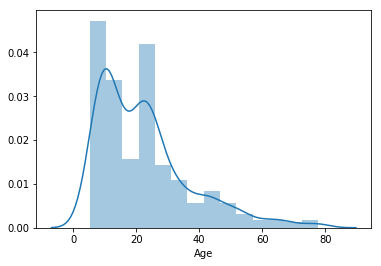

In [9]:
sns.distplot(nndsp_pheno.age_at_scan, bins = num_bins(nndsp_pheno, "age_at_scan"), axlabel="Age")
pyplot.show()

## Resampling NKI

In [42]:
nki_pheno = pd.read_csv(nki_phenoFile, sep='\t')

In [43]:
nki_pheno = nki_pheno[['participant_id', 'age']]
nki_pheno.participant_id = [int(x[1:]) for x in nki_pheno.participant_id]
nki_pheno = nki_pheno.sort_values(by='age')
nki_pheno = nki_pheno.set_index([np.arange(0, len(nki_pheno))])
nki_pheno.head()

,participant_id,age
0,62349,6.0
1,51691,6.0
2,56020,6.0
3,65185,6.0
4,40117,6.0


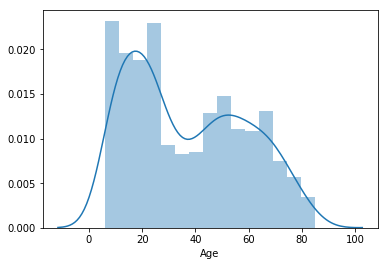

In [44]:
sns.distplot(nki_pheno.age, bins = num_bins(nki_pheno, "age"), axlabel="Age")
pyplot.show()

### NKI:NNDSP

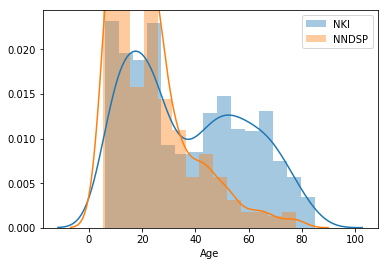

In [45]:
sns.distplot(nki_pheno.age, bins = num_bins(nki_pheno, "age"), axlabel="Age", label = "NKI")
sns.distplot(nndsp_pheno.age_at_scan, bins = num_bins(nndsp_pheno, "age_at_scan"), axlabel="Age", label = "NNDSP")
pyplot.legend()
pyplot.show()

In [46]:
nki_dist = get_bucket_dist(nki_pheno, "age", to_print=False)
nndsp_dist = get_bucket_dist(nndsp_pheno, "age_at_scan", to_print=False)

In [47]:
df_dist_nki = df_from_dist(nki_pheno, "age", "participant_id", nki_dist, nndsp_pheno, nndsp_dist)
df_dist_nki = df_dist_nki.sort_values(by='age')

   participant_id  age
0           62349  6.0
1           51691  6.0
2           56020  6.0
3           65185  6.0
4           40117  6.0


In [48]:
df_dist_nki.head()

,participant_id,age
3,65185,6.0
4,40117,6.0
11,53873,6.0
10,59734,6.0
5,55832,6.0


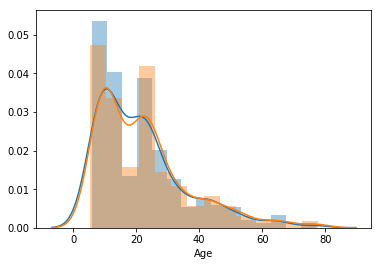

In [49]:
sns.distplot(df_dist_nki.age)
sns.distplot(nndsp_pheno.age_at_scan, bins = num_bins(nndsp_pheno, "age_at_scan"), axlabel="Age", label = "NNDSP")
pyplot.show()

### NKI:HCP

## Resampling CORRS

In [55]:
corrs_pheno = pd.read_csv(corrs_phenoFile)

In [56]:
corrs_pheno = corrs_pheno[["SUBID", "AGE_AT_SCAN_1"]]
corrs_pheno = corrs_pheno.drop_duplicates()
corrs_pheno = corrs_pheno[corrs_pheno.AGE_AT_SCAN_1 != "NoPhenotypicData"]
corrs_pheno = corrs_pheno[corrs_pheno.AGE_AT_SCAN_1 != "#"]
corrs_pheno.AGE_AT_SCAN_1 = [float(x) for x in corrs_pheno.AGE_AT_SCAN_1]
corrs_pheno = corrs_pheno.sort_values(by="AGE_AT_SCAN_1")
corrs_pheno = corrs_pheno.set_index([np.arange(0, len(corrs_pheno))])
corrs_pheno.head()

,SUBID,AGE_AT_SCAN_1
0,26077,6.0
1,26076,6.0
2,26078,6.0
3,26079,6.0
4,26082,6.0


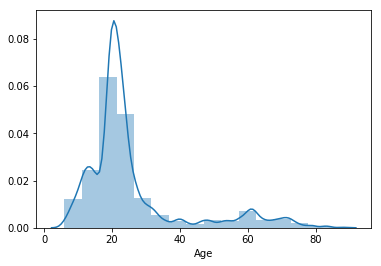

In [57]:
sns.distplot(corrs_pheno.AGE_AT_SCAN_1, bins = num_bins(corrs_pheno, "AGE_AT_SCAN_1"), axlabel="Age")
pyplot.show()

### CORRS:NNDSP

In [58]:
corrs_dist = get_bucket_dist(corrs_pheno, "AGE_AT_SCAN_1", to_print=False)
nndsp_dist = get_bucket_dist(nndsp_pheno, "age_at_scan", to_print=False)

In [59]:
df_dist_corrs = df_from_dist(corrs_pheno, "AGE_AT_SCAN_1", "SUBID", corrs_dist, nndsp_pheno, nndsp_dist)
df_dist_corrs = df_dist_corrs.sort_values(by='AGE_AT_SCAN_1')

   SUBID  AGE_AT_SCAN_1
0  26077            6.0
1  26076            6.0
2  26078            6.0
3  26079            6.0
4  26082            6.0


In [60]:
df_dist_corrs.head()

,SUBID,AGE_AT_SCAN_1
4,26082,6.0
2,26078,6.0
1,26076,6.0
0,26077,6.0
3,26079,6.0


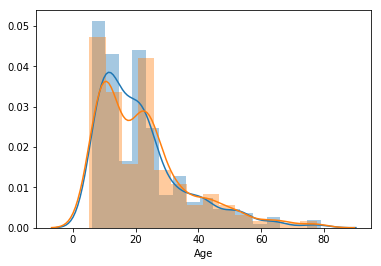

In [61]:
sns.distplot(df_dist_corrs.AGE_AT_SCAN_1)
sns.distplot(nndsp_pheno.age_at_scan, bins = num_bins(nndsp_pheno, "age_at_scan"), axlabel="Age", label = "NNDSP")
pyplot.show()

### CORRS:HCP

## Resampling SALD

In [73]:
sald_pheno = pd.read_excel(sald_phenoFile)

In [74]:
sald_pheno = sald_pheno[['Sub_ID', 'Age']]
sald_pheno = sald_pheno.sort_values(by='Age')
sald_pheno = sald_pheno.set_index([np.arange(0, len(sald_pheno))])
sald_pheno.head()

,Sub_ID,Age
0,31543,19
1,31593,19
2,31611,19
3,31566,19
4,31594,20


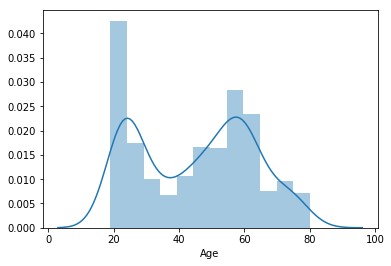

In [75]:
sns.distplot(sald_pheno.Age, bins = num_bins(sald_pheno, "Age"), axlabel="Age")
pyplot.show()

### SALD:NNDSP

In [124]:
sald_dist = get_bucket_dist(sald_pheno, "Age", to_print=False)
nndsp_dist = get_bucket_dist(nndsp_pheno, "age_at_scan", to_print=False)

In [125]:
df_dist_sald = df_from_dist(sald_pheno, "Age", "Sub_ID", sald_dist, nndsp_pheno, nndsp_dist)
df_dist_sald = df_dist_sald.sort_values(by="Age")

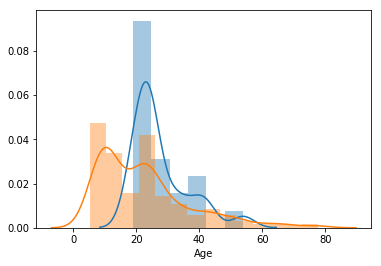

In [126]:
sns.distplot(df_dist_sald.Age)
sns.distplot(nndsp_pheno.age_at_scan, bins = num_bins(nndsp_pheno, "age_at_scan"), axlabel="Age", label = "NNDSP")
pyplot.show()

### SALD:HCP